In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import os
import random
import timeit
from keras.models import load_model, Model
from PIL import Image
from pymongo import MongoClient
from sklearn.metrics.pairwise import euclidean_distances


MODELO = 'GPUNormal100Epoch'

/home/ivan/pybr/ajna_docs/padma/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from ajna_commons.flask.conf import DATABASE, MONGODB_URI
from padma.gym.utils import monta_lista_ids_e_imagens, view_imagens


2018-10-02 08:34:35,439 ajna         INFO     Configuração de log efetuada


Fazendo log de erros e alertas no arquivo  /home/ivan/pybr/ajna_docs/padma/ajna_commons/flask/error.log
Fazendo log de atividade no arquivo  /home/ivan/pybr/ajna_docs/padma/ajna_commons/flask/access.log


In [4]:
def get_cursor_indices(limit=50000, batch_size=1000):
    db = MongoClient(host=MONGODB_URI)[DATABASE]
    cursor = db['fs.files'].find(
        {'metadata.predictions.index': {'$exists': True, '$ne': None}},
        {'metadata.predictions.index': 1}
    ).limit(limit).batch_size(batch_size)
    return cursor


In [5]:
limite = 10
# Comentar a linha abaixo para apenas testar o script
# limite = float(inf)
cursor = get_cursor_indices(limite)

In [6]:
indexes = list(cursor)

In [7]:
len(indexes)

10

In [8]:
print(indexes[0])

{'_id': ObjectId('5aa18b522a87953d7d028c1d'), 'metadata': {'predictions': [{'index': [0.0, 1.4773788452148438, 0.0, 0.7240659594535828, 0.4069342017173767, 0.0, 0.0, 0.6478644609451294, 0.0, 1.0105177164077759, 0.0, 0.2989659905433655, 0.20283083617687225, 0.0, 0.0, 0.16964936256408691, 0.0, 1.1026967763900757, 0.0, 0.47831282019615173, 0.29627859592437744, 0.0, 0.09054635465145111, 0.34273961186408997, 0.0, 1.4906352758407593, 0.06937331706285477, 0.5175421237945557, 0.6970318555831909, 0.0, 0.02550847828388214, 0.29032543301582336, 0.03779888153076172, 1.7319986820220947, 0.0, 0.9171586632728577, 0.19078324735164642, 0.0, 0.0, 0.6585122346878052, 0.0, 1.3632667064666748, 0.0, 0.629180371761322, 0.5043202042579651, 0.0, 0.051361873745918274, 0.0, 0.0, 1.1925997734069824, 0.1568969190120697, 0.8706746697425842, 0.39224904775619507, 0.0, 0.16097943484783173, 0.6473591327667236, 0.0, 1.6544342041015625, 0.038585297763347626, 0.9003276824951172, 0.5222610235214233, 0.0, 0.0, 0.25954705476

In [9]:
print(np.asarray(indexes[0].get('metadata').get('predictions')[0].get('index')).mean())

0.34075109867262654


In [10]:
def monta_indexes():
    np_indexes = [index.get('metadata').get('predictions')[0].get('index') for index in indexes]
    return np.asarray(np_indexes, dtype=np.float16)


In [11]:
timeit.timeit(stmt='monta_indexes()', number=1, globals=globals())


8.205999995425373e-05

In [12]:
np_indexes = monta_indexes()

In [13]:
print(np_indexes.shape)
print("%d kbytes" % ((np_indexes.size * np_indexes.itemsize) / 1000))

(10, 128)
2 kbytes


In [16]:
import time

In [17]:
def get_distances():
    i = random.randint(0, np_indexes.shape[0] - 1)
    s0 = time.time()
    distances = euclidean_distances([np_indexes[i]], np_indexes)
    s1 = time.time()
    sequence = np.argsort(distances)
    s2 = time.time()
    print(s1 - s0, s2 - s1)
    return i, distances, sequence

In [18]:
timeit.timeit(stmt='get_distances()', number=20, globals=globals())

0.0003905296325683594 1.1920928955078125e-05
0.00019502639770507812 1.0013580322265625e-05
0.0003559589385986328 1.0728836059570312e-05
0.00032639503479003906 1.2636184692382812e-05
0.00019049644470214844 1.0251998901367188e-05
0.0001628398895263672 9.5367431640625e-06
0.0009207725524902344 2.5510787963867188e-05
0.0006647109985351562 2.0503997802734375e-05
0.0005707740783691406 1.9550323486328125e-05
0.0005092620849609375 1.7404556274414062e-05
0.0005180835723876953 1.71661376953125e-05
0.0023374557495117188 1.811981201171875e-05
0.0003142356872558594 1.52587890625e-05
0.0002911090850830078 1.430511474609375e-05
0.00024390220642089844 1.0967254638671875e-05
0.0004100799560546875 4.76837158203125e-05
0.0003833770751953125 1.8358230590820312e-05
0.00019931793212890625 1.4066696166992188e-05
0.00019240379333496094 1.1444091796875e-05
0.00016832351684570312 1.3828277587890625e-05


0.015218548999996528

In [81]:
np_indexes = np.asarray(np_indexes, dtype=np.float32)
get_distances()

0.07161641120910645 0.06641817092895508


(303452, array([[4.106318 , 4.8764324, 5.0056744, ..., 6.254734 , 6.579182 ,
         7.2212396]], dtype=float32), array([[303452, 368674, 354207, ..., 105650, 439560, 300545]]))

In [82]:
timeit.timeit(stmt='get_distances()', number=20, globals=globals())

0.07207369804382324 0.06556391716003418
0.09933710098266602 0.0812687873840332
0.08136463165283203 0.06507658958435059
0.08527255058288574 0.0654296875
0.08671212196350098 0.0699009895324707
0.08312654495239258 0.06589961051940918
0.11107110977172852 0.06728887557983398
0.08910441398620605 0.06509971618652344
0.09496402740478516 0.11408638954162598
0.08648109436035156 0.06757950782775879
0.08600020408630371 0.07281255722045898
0.07537674903869629 0.06412672996520996
0.09582757949829102 0.0885922908782959
0.0712435245513916 0.06453776359558105
0.08504819869995117 0.10070538520812988
0.07212471961975098 0.0654759407043457
0.11352014541625977 0.07496309280395508
0.07313895225524902 0.0646967887878418
0.08173394203186035 0.07030940055847168
0.07697510719299316 0.06493949890136719


3.1839732489997914

In [73]:
timeit.timeit(stmt='get_distances()', number=50, globals=globals())

0.0831151008605957 0.06787705421447754
0.07760453224182129 0.06500577926635742
0.09825491905212402 0.06613779067993164
0.07592201232910156 0.06506180763244629
0.08391022682189941 0.06854629516601562
0.07704687118530273 0.06548738479614258
0.08185219764709473 0.06790947914123535
0.077789306640625 0.06493449211120605
0.08282470703125 0.0678861141204834
0.07746005058288574 0.06490540504455566
0.10006165504455566 0.06517577171325684
0.07725811004638672 0.06467127799987793
0.08279275894165039 0.0704047679901123
0.078277587890625 0.06495308876037598
0.10008049011230469 0.06575226783752441
0.0745697021484375 0.06461811065673828
0.10040569305419922 0.06751561164855957
0.07534193992614746 0.0648488998413086
0.08441853523254395 0.06741929054260254
0.0800325870513916 0.06809663772583008
0.08428478240966797 0.06636881828308105
0.07955622673034668 0.06570887565612793
0.09080839157104492 0.06795501708984375
0.07882881164550781 0.06680154800415039
0.0895833969116211 0.11368298530578613
0.081483840942

8.00624850999975

In [83]:
from gridfs import GridFS
from bson.objectid import ObjectId
import io

def mongo_image(image_id):
    """Lê imagem do Banco MongoDB. Retorna None se ID não encontrado."""
    db = MongoClient(host=MONGODB_URI)[DATABASE]
    fs = GridFS(db)
    # _id = ObjectId(image_id)
    _id = image_id
    if fs.exists(_id):
        grid_out = fs.get(_id)
        image = grid_out.read()
        return Image.open(io.BytesIO(image))
    return None

In [84]:
i, dist, seq = get_distances()
seq = seq.reshape(seq.shape[1])
seq.shape

1.092803955078125 0.09176325798034668


(446933,)

In [85]:
lista_ids = [index.get('_id') for index in indexes]
lista_ids = np.asarray(lista_ids)
lista_ids[seq[0]]


ObjectId('5aabfab12a879503d8061310')

In [86]:
np.save('indexes.npy', np_indexes)
np.save('_ids.npy', np.asarray(lista_ids))

0.08999896049499512 0.06621742248535156
[437415 437147 406664 172902 432531 446747 437303 423278 436669 425399
 164397 440531 432718 305749 434781 441754 405901 421779 420975 433468]


/home/ivan/pybr/ajna_docs/padma/venv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

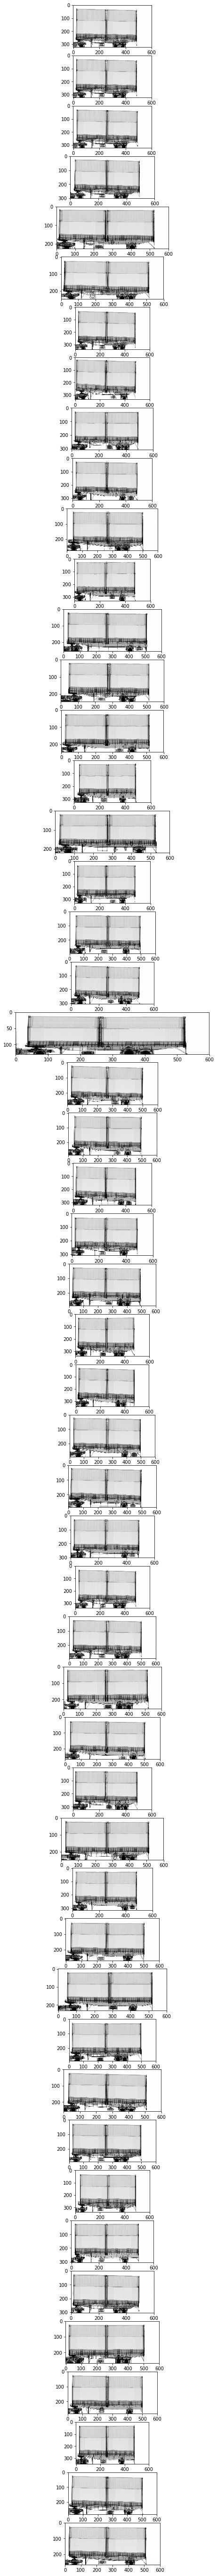

In [87]:
i, dist, seq = get_distances()
seq = seq.reshape(seq.shape[1])
print(seq[:20])

plt.gray()
fig=plt.figure(figsize=(10, 100))
for r in range(50):
    ax = fig.add_subplot(51, 1, 1)
    plt.imshow(mongo_image(lista_ids[i]))
    ax = fig.add_subplot(51, 1, r + 2)
    plt.imshow(mongo_image(lista_ids[seq[r]]))
plt.show()